In [1]:
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.autograd import Variable
from sklearn.svm import SVC

import RNN_neurons
from InputPatterns import match_to_sample_input, repeat_sequence_input
import Solver
# from RNN_neurons import RnnForNeurons
%load_ext autoreload

%autoreload 1
%aimport Solver, RNN_neurons, Solver, InputPatterns

In [ ]:
#Upload the models 
# Initialize the Solver.RunMod with corresponding parameters and 
#load the object_name.load_state_dict(torch.load('saved_dict'))
# Net - network with 200 neurons trained in 100 trials for sample-to-match task
# Net_{G/E/D/C} - netwroks for each pitch for repeat-the-sequence task

#E.g.
# Net.net.load_state_dict(torch.load('Net2000n_dict'))

In [3]:
# Function for plotting eigenvalues of the synaptic matrix
def argand(a,b):
    plt.figure(figsize=(20,20))
    for x in range(len(b)):
        plt.plot([0,b[x].real],[0,b[x].imag],'ko')
    for x in range(len(a)):
        plt.plot([0,a[x].real],[0,a[x].imag],'bo')
    
    plt.ylabel('Imaginary')
    plt.xlabel('Real')
    plt.show()

## Check Performance

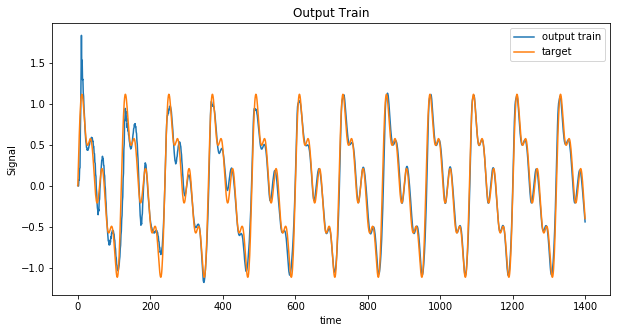

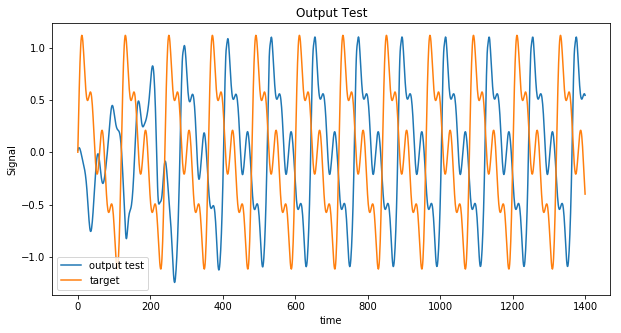

In [222]:
#Parameters

num_neurons=100# number of neurons
output_size=1 # number of output channels 
input_size = 1 # number of input channels 
tau=10 # relaxation constant 
g=1.5 # synapses scaling parameter
alpha=1 # learning rate
delta_t = 2 # interval of time between modifications
simtime=1400 # simulation time

# Construct the target signal 
amp = 1.3;
freq = 1/60;
sin1 =  [np.sin(1.0*np.pi*freq* t) for t in range(simtime)]
sin2 = (amp/2) * np.array([np.sin(2.0*np.pi*freq* t) for t in range(simtime)])
sin3 = (amp/6) * np.array([np.sin(3.0*np.pi*freq* t) for t in range(simtime)])
sin4 = (amp/3) * np.array([np.sin(4.0*np.pi*freq* t) for t in range(simtime)])

target = sin1 + sin2 + sin3 + sin4

target = np.array(target/1.5)
# target = target.float()

length_input=target.shape[0]
signal = np.zeros((1,simtime))

#create and initialize the network
Net_check = RNN_neurons.RnnForNeurons(num_neurons, input_size, output_size, tau, g)
eig_before = np.linalg.eigvals(Net_check.state_dict()['gen_layer.synapses']) #get the eigenvalues of the net prior to training

#train
output, potentials_record = Solver.run(Net_check, signal, return_measures=True, train=True, delta_t=delta_t, alpha=alpha, lengthSignal=simtime, target=target, check_error_update=False)

#test
output_test = Solver.run(Net_check, signal,lengthSignal=simtime)

# plot output

plt.figure(figsize=(10,5))
plt.title('Output Train')
plt.xlabel('time')
plt.ylabel('Signal')
plt.plot(output.cpu().detach().numpy(), label = 'output train')
plt.plot(target, label = 'target')
plt.legend()

plt.figure(figsize=(10,5))
plt.title('Output Test')
plt.xlabel('time')
plt.ylabel('Signal')
plt.plot(output_test.cpu().detach().numpy(), label = 'output test')
plt.plot(target, label ='target')
plt.legend()

In [ ]:
# Plot eigenvalues

eig_after = np.linalg.eigvals(Net_check.net.state_dict()['gen_layer.synapses'])
argand(eig_before,eig_after)

## Task #1: match-to-sample


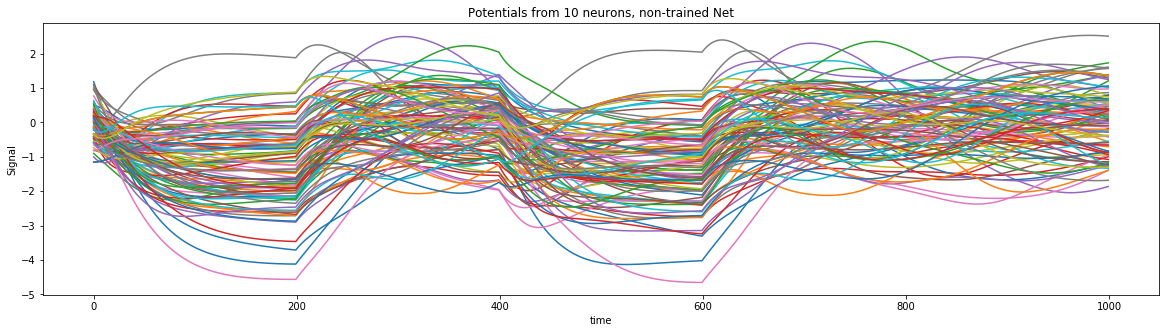

In [259]:
#Check how the not trained Net reacts to the same input: transition from chaotic to non-chaotic activity

#Parameters
num_neurons=1000
input_size=2
output_size=1
tau=30
g=1.5
lengthStimulus = 200
delay = 200
lengthSignal = 1000
num_trials=1
delta_t = 2

# signal:
signal, target, trial_target = match_to_sample_input(num_trials,lengthStimulus,delay,lengthSignal)

Net_nontrained = RNN_neurons.RnnForNeurons(num_neurons, input_size, output_size, tau, g)

output, potentials_record = Solver.run(Net_nontrained, signal, return_measures=True)

# Plot potentials of 10 neurons
plt.figure(figsize=(20,5))
plt.title('Potentials from 10 neurons, non-trained Net')
plt.xlabel('time')
plt.ylabel('Signal')
neurons =  np.random.choice(num_neurons, 100)
for neuron in neurons:
  plt.plot(potentials_record[neuron,:].numpy(), label='neuron'+str(neuron))

In [260]:
a = torch.Tensor(5,5)
print(torch.distributions.normal.Normal(0,1).sample((5,5)))
torch.nn.init.normal_(a,0,0.1)

tensor([[-3.2281e-02, -1.9880e-03,  1.0854e+00, -6.7495e-01, -2.2240e-01],
        [-2.5546e-01, -6.2625e-01,  1.1801e+00, -2.3355e+00, -1.1527e+00],
        [ 3.1467e-01, -1.3458e+00, -2.4084e+00, -1.3052e-01,  7.6248e-01],
        [-4.7905e-01,  3.3844e-01, -6.6769e-01,  9.5624e-01, -8.3368e-01],
        [-9.6804e-01, -1.4152e-01,  1.5033e+00, -4.2387e-01, -1.0563e+00]])


tensor([[-0.0938, -0.0818,  0.0311, -0.1848, -0.2435],
        [ 0.3077,  0.1306,  0.3007,  0.1570,  0.0757],
        [ 0.0650,  0.0616,  0.1173, -0.2153,  0.0012],
        [-0.2329, -0.1628, -0.0479, -0.1338,  0.0168],
        [-0.1433, -0.1388, -0.1224,  0.0753, -0.1682]])

target: 0.0


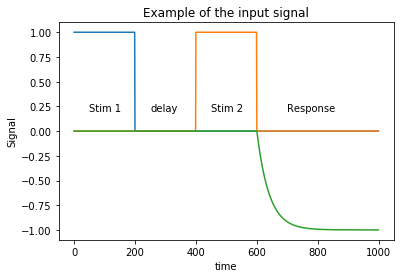

In [261]:
#Visualize input and target example
lengthStimulus = 200
delay = 200
lengthSignal = 1000
num_trials=100

# generate input signal and target signal
signal, target, trial_target = match_to_sample_input(num_trials,lengthStimulus,delay,lengthSignal)

plt.plot(signal[0,:lengthSignal])
plt.plot(signal[1,:lengthSignal])
plt.plot(target[:lengthSignal])
plt.title('Example of the input signal')
plt.xlabel('time')
plt.ylabel('Signal')

plt.text(lengthStimulus + delay/4, 0.2, 'delay')
plt.text(lengthStimulus/4, 0.2, 'Stim 1')
plt.text(lengthStimulus * 5/4 + delay, 0.2, 'Stim 2')
plt.text(lengthStimulus * 10/4  + delay , 0.2, 'Response')


print('target:', target[0])

In [304]:
#TRAIN for sample-to-match task

#Parameters for Network
num_neurons=2000 #number of neurons
input_size=2 #number of input channels
output_size=1 #number of output channels 
tau=30 #relaxation constant 
g=1.5 #synapses scaling parameter
alpha = 10 #learning rate
delta_t = 2 #interval of time between modifications

#Parameters for signal
lengthStimulus = 200
delay = 200
lengthSignal = 1000 


# initialize the net 
Net = RNN_neurons.RnnForNeurons(num_neurons, input_size, output_size, tau, g)
eig_before = np.linalg.eigvals(Net.state_dict()['gen_layer.synapses']) #get the eigenvalues of the net prior to training

acc_train = np.zeros(10)
acc_test = np.zeros(10)

for epoch in range(10): #each epoch trains the Net of 100 trials and checks it on other 100 trials
  num_trials = 100
  num_trial_test = 100
  # signal for train:
  signal, target, trial_target = match_to_sample_input(num_trials,lengthStimulus,delay,lengthSignal)

  # signal for tests:
  signal_test, target_test, trial_target = match_to_sample_input(num_trial_test,lengthStimulus,delay,lengthSignal)

  #train
  output = Solver.run(Net, signal, return_measures=False, train=True, delta_t=delta_t, alpha=alpha, target=target, check_error_update=False)
  
  print('Trial:', (epoch+1)*100)
  #Train error: take the mean of output for the response time and check the sign
  response = lengthSignal-2*lengthStimulus-delay
  error = np.empty(num_trials)
  for trial in range(num_trials):
    error[trial] = np.sign(np.mean(output[(trial*lengthSignal)+response:lengthSignal*(trial+1)].detach().cpu().numpy())) == trial_target[trial]
  accuracy = np.mean(error)
  acc_train[epoch] = accuracy
  print('Train accuracy:', accuracy)
  
  #test
  output_test = Solver.run(Net, signal_test)

  #Trial error: take the mean of output for the response time and check the sign
  response = lengthSignal-2*lengthStimulus-delay
  error = np.empty(num_trial_test)
  for trial in range(num_trial_test):
    error[trial] = np.sign(np.mean(output_test[(trial*lengthSignal)+response:lengthSignal*(trial+1)].detach().cpu().numpy())) == trial_target[trial]
  accuracy = np.mean(error)
  acc_test[epoch] = accuracy
  print('Test accuracy:', accuracy)

 

# Training Net with 2000n Results:
# Trial: 100
# Train accuracy: 0.44
# Test accuracy: 0.87
# Trial: 200
# Train accuracy: 0.49
# Test accuracy: 0.96

Trial: 100
Train accuracy: 0.49
Test accuracy: 0.87
Trial: 200
Train accuracy: 0.49
Test accuracy: 0.96
Trial: 300
Train accuracy: 0.52
Test accuracy: 1.0


KeyboardInterrupt: 

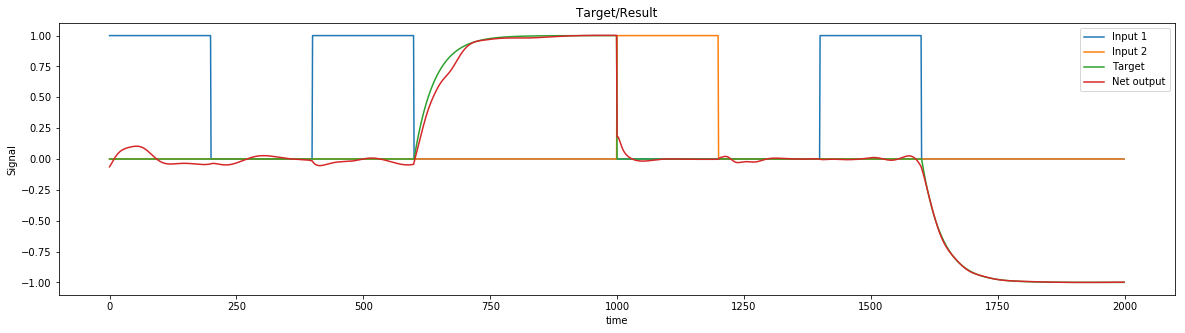

In [317]:
#TEST the trained Net on sample-to-match task

# #Parameters for Network
# num_neurons=2000 #number of neurons
# input_size=2 #number of input channels
# output_size=1 #number of output channels 
# tau=30 #relaxation constant 
# g=1 #synapses scaling parameter
# alpha = 10 #learning rate
# delta_t = 2 #interval of time between modifications
# Net = Solver.run(Net, num_neurons, input_size, output_size, tau, g)
# Net.net.load_state_dict(torch.load('Net2000n_dict'))

lengthStimulus = 200
delay = 200
lengthSignal = 1000
num_trial_test = 2



# # signal for tests:
signal_test, target_test, trial_target = match_to_sample_input(num_trial_test,lengthStimulus,delay,lengthSignal)

output_test, potentials_record = Solver.run(Net, signal_test, return_measures=True)

#Plot the output 
plt.figure(figsize=(20,5))
plt.title('Target/Result')
plt.xlabel('time')
plt.ylabel('Signal')
plt.plot(signal_test[0,:], label='Input 1')
plt.plot(signal_test[1,:], label='Input 2')
plt.plot(target_test, label='Target')
plt.plot(output_test.cpu().detach().numpy(), label = 'Net output')
plt.legend()

In [318]:
torch.save(Net, 'Net_match_to_sample')

In [19]:
#Get traces of patterns for analysis:
num_trial_test=1
lengthStimulus = 200
delay = 200
lengthSignal = 1000

#pattern AA
signal_test, target_test, trial_target = match_to_sample_input(num_trial_test,lengthStimulus,delay,lengthSignal,pattern='AA')
output_test, pattern1 = Solver.run(Net, signal_test, return_measures=True)

#pattern AB
signal_test, target_test, trial_target = match_to_sample_input(num_trial_test,lengthStimulus,delay,lengthSignal,pattern='AB')
output_test, pattern2 = Solver.run(Net, signal_test, return_measures=True)

#pattern BB
signal_test, target_test, trial_target = match_to_sample_input(num_trial_test,lengthStimulus,delay,lengthSignal,pattern='BB')
output_test, pattern3 = Solver.run(Net, signal_test, return_measures=True)

#pattern BA
signal_test, target_test, trial_target = match_to_sample_input(num_trial_test,lengthStimulus,delay,lengthSignal,pattern='BA')
output_test, pattern4 = Solver.run(Net, signal_test, return_measures=True)

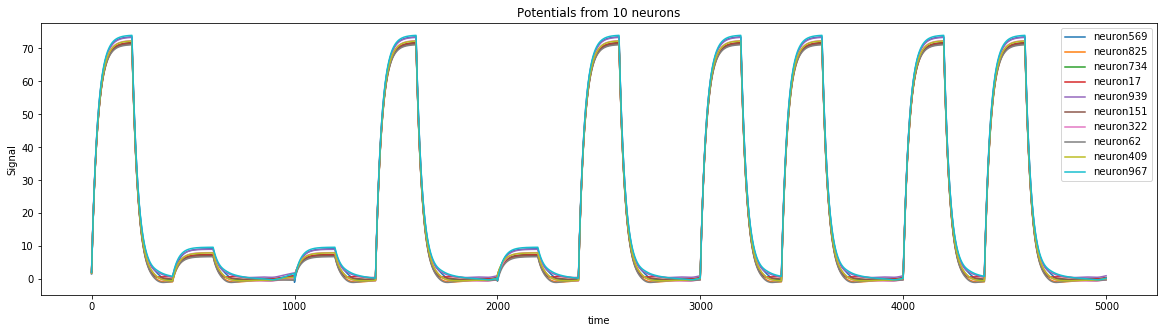

In [20]:
# Plot potentials from 10 neurons in the trained network: transition from chaotic to non-chaotic activity

plt.figure(figsize=(20,5))
plt.title('Potentials from 10 neurons')
plt.xlabel('time')
plt.ylabel('Signal')
for neuron in neurons:
  plt.plot(potentials_record[neuron,0:5000].numpy(), label='neuron'+str(neuron))
plt.legend()

## Response to different delays

In [ ]:
# Chnage the delay (for the Net trained on 200ms delay)

lengthStimulus = 200

lengthSignal = 1000
num_trial_test = 20

acc_delay = np.array([])

for delay in [50,100,200,300,400]: # try delays: 50ms, 100ms, 200ms, 300ms, 400ms
  
  # signal for tests:
  signal_test, target_test, trial_target = match_to_sample_input(num_trial_test,lengthStimulus,delay,lengthSignal)
  
  #test
  output_test, potentials_record = Solver.run(Net, signal_test, return_measures=True)
  
  #Accuracy
  #Trial error: take the mean of output for the response time and check the sign
  print('Delay:', delay)
  response = lengthSignal-2*lengthStimulus-delay
  error = np.empty(num_trial_test)
  for trial in range(num_trial_test):
    error[trial] = np.sign(sum(output_test[(trial*lengthSignal)+response:lengthSignal*(trial+1)])/response) == trial_target[trial]
  accuracy = sum(error)/num_trial_test
  acc_delay = np.append(acc_delay, accuracy)
  print('Accuracy on 20 trials:', accuracy)
  
  #Plot the input and Net output for each delay
  
  plt.figure(figsize=(20,5))
  plt.title('Target/Result with delay:' + str(delay))
  plt.xlabel('time')
  plt.ylabel('Signal')
  plt.plot(signal_test[0,:].numpy(), label='Input 1')
  plt.plot(signal_test[1,:].numpy(), label='Input 2')
  plt.plot(target_test.numpy(), label='Target')
  plt.plot(output_test.numpy(), label = 'Net output')
  plt.legend()


In [ ]:
# Plot Net test accuracy vs delay
plt.figure()
plt.title('Accuracy for input with different delays')
plt.xlabel('delay')
plt.ylabel('Accuracy on 20 trials')
plt.plot([50,100,200,300,400], acc_delay)
plt.scatter([50,100,200,300,400], acc_delay,c='r')

# Eigenvalues of synapses matrix

In [ ]:
#Plot eigenvalues of synapses matrix
#Parameters
num_neurons=1000
input_size=2
output_size=1
tau=30
g=1
lengthStimulus = 200
delay = 200
lengthSignal = 1000
num_trials=20
delta_t = 2

# signal:
Net_nontrained = RNN_neurons.RNNForNeurons(num_neurons, input_size, output_size, tau, g)
eig_before = np.linalg.eigvals(Net_nontrained.state_dict()['gen_layer.synapses'])
eig_after = np.linalg.eigvals(Net.state_dict()['gen_layer.synapses'])

argand(eig_before,eig_after)


# State-space analysis

In [ ]:
# Find equilibrium points and determine their stability

synapses = Net.state_dict()['gen_layer.synapses'].numpy()
weights_input = Net.state_dict()['input_map.weight'].numpy()
#signal_test - full input

# Find where delta_x = 0
delta_x = -potentials_record.numpy() + np.matmul(synapses.T,np.tanh(potentials_record.numpy())) + np.matmul(weights_input, signal_test)
delta_x = np.sum(delta_x**2, axis = 0)
equil = np.array(np.where(abs(delta_x)<=0.008))

# Find Jacobian for fix point, find its eigenvalues and determine their sign
for point in equil[0]:
    print(point)
    jacobian = np.zeros((2000,2000))
    diag = np.eye(2000)*-1
    potential = potentials_record.numpy().T[point]
    for i in range(2000):
        jacobian[i] = [synapses.T[i,j]*(1-np.tanh(potential[j])**2) for j in range(2000)]
    jacobian = jacobian + diag
    eigenvalues = np.linalg.eigvals(jacobian)
    
    # Check stability: real part of eigenvalues should be smaller than 0
    for value in eigenvalues:
        if value.real > 0:
            print('Not stable')

In [ ]:
#Plot the state space and put equilibrium points

from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# PCA observation - each t, features - neurons' state
pca = PCA(n_components=3)
projected_data1 = pca.fit_transform(potentials_record.numpy().T) #project data to three main components


fig = plt.figure(figsize=(10,10))
plt.title('3D state space')
ax1 = fig.add_subplot(111, projection='3d')


for trial in range(num_trial_test):
  if trial_target[trial] == 1:
    ax1.plot(projected_data1[lengthSignal*trial:lengthSignal*(trial+1),0],projected_data1[lengthSignal*trial:lengthSignal*(trial+1),1],projected_data1[lengthSignal*trial:lengthSignal*(trial+1),2],c='b') 
  else:
    ax1.plot(projected_data1[lengthSignal*trial:lengthSignal*(trial+1),0],projected_data1[lengthSignal*trial:lengthSignal*(trial+1),1],projected_data1[lengthSignal*trial:lengthSignal*(trial+1),2],c='r') 

ax1.scatter(projected_data1[equil[0,0]][0], projected_data1[equil[0,0]][1], projected_data1[equil[0,0]][2], c='g',marker='x', s = 200)      
ax1.scatter(projected_data1[equil[0,1]][0], projected_data1[equil[0,1]][1], projected_data1[equil[0,1]][2], c='g',marker='x', s = 200)      

ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')


In [ ]:
#Plot the state space for different patterns
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# PCA observation - each t, features - neurons' state
pca = PCA(n_components=3)
projected_data1 = pca.fit_transform(pattern1.numpy().T)
projected_data2 = pca.fit_transform(pattern2.numpy().T)
projected_data3 = pca.fit_transform(pattern3.numpy().T)
projected_data4 = pca.fit_transform(pattern4.numpy().T)

t_p = [100,500,600] #time points to look at
time = np.arange(0,1000)

fig = plt.figure(figsize=(20,20))
plt.title('3D state space')
ax1 = fig.add_subplot(221, projection='3d')
sc1 = ax1.scatter(projected_data1[:,0],projected_data1[:,1],projected_data1[:,2], c=time, cmap='jet')
ax1.set_title('AA')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')
fig.colorbar(sc1,label='Time of signal')
ax1.legend()


ax2 = fig.add_subplot(222, projection='3d')
sc2 = ax2.scatter(projected_data2[:,0],projected_data2[:,1],projected_data2[:,2], c=time, cmap='jet')
ax2.set_title('AB')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_zlabel('PC3')
fig.colorbar(sc2,label='Time of signal')
ax2.legend()

ax3 = fig.add_subplot(223, projection='3d')
sc3 = ax3.scatter(projected_data3[:,0],projected_data3[:,1],projected_data3[:,2], c=time, cmap='jet')
ax3.set_title('BB')
ax3.set_xlabel('PC1')
ax3.set_ylabel('PC2')
ax3.set_zlabel('PC3')
fig.colorbar(sc3,label='Time of signal')
ax3.legend()

ax4 = fig.add_subplot(224, projection='3d')
sc4 = ax4.scatter(projected_data4[:,0],projected_data4[:,1],projected_data4[:,2], c=time, cmap='jet')
ax4.set_title('BA')
ax4.set_xlabel('PC1')
ax4.set_ylabel('PC2')
ax4.set_zlabel('PC3')
fig.colorbar(sc4,label='Time of signal')
ax4.legend()
    
plt.show()

# Multidimensional Scaling

In [ ]:
# Multidimensional Scaling

#PCA observation - each t, features - neurons' state
from sklearn.manifold import MDS
embedding = MDS(n_components=2, max_iter=100)
# for this first the Net run 2 trials on each pattern, the resulted potentials records are saved and concatinated 
potentials_record = np.concatenate((pattern1,pattern2,pattern3,pattern4),axis=1)
data_for_mds = potentials_record.astype(np.float64)
projected_data = embedding.fit_transform(data_for_mds.T)


fig = plt.figure(figsize=(10,10))
trial_target = [1,1,1,-1,-1,-1,10,10,10,-10,-10,-10]
ax1 = fig.add_subplot(221)
for tr in range(12):
  if trial_target[tr]==1:
    ax1.scatter(projected_data[lengthSignal*tr+200-1,0],projected_data[lengthSignal*tr+200-1,1], c='b', marker='o',s=200)
  elif trial_target[tr]==10:
    ax1.scatter(projected_data[lengthSignal*tr+200-1,0],projected_data[lengthSignal*tr+200-1,1], c='b', marker='*',s=400)
  elif trial_target[tr]==-10:
    ax1.scatter(projected_data[lengthSignal*tr+200-1,0],projected_data[lengthSignal*tr+200-1,1], c='r', marker='*',s=400)
  else:
    ax1.scatter(projected_data[lengthSignal*tr+200-1,0],projected_data[lengthSignal*tr+200-1,1], c='r', marker='o',s=200)
ax1.set_title('Time: 200ms')
ax1.set_xlabel('Dimension 1')
ax1.set_ylabel('Dimension 2')
ax1.legend()

ax2 = fig.add_subplot(222)
for tr in range(12):
  if trial_target[tr]==1:
    ax2.scatter(projected_data[lengthSignal*tr+650,0],projected_data[lengthSignal*tr+600-1,1], c='b', marker='o',s=200)
  elif trial_target[tr]==10:
    ax2.scatter(projected_data[lengthSignal*tr+650,0],projected_data[lengthSignal*tr+600-1,1], c='b', marker='*',s=400)
  elif trial_target[tr]==-10:
    ax2.scatter(projected_data[lengthSignal*tr+650,0],projected_data[lengthSignal*tr+600-1,1], c='r', marker='*',s=400)
  else:
    ax2.scatter(projected_data[lengthSignal*tr+650,0],projected_data[lengthSignal*tr+600-1,1], c='r', marker='o',s=200)
ax2.set_title('Time: 650ms')
ax2.set_xlabel('Dimension 1')
ax2.set_ylabel('Dimension 2')
ax2.legend()

ax3 = fig.add_subplot(223)
for tr in range(12):
  if trial_target[tr]==1:
    ax3.scatter(projected_data[lengthSignal*tr+800-1,0],projected_data[lengthSignal*tr+800-1,1], c='b', marker='o',s=200)
  elif trial_target[tr]==10:
    ax3.scatter(projected_data[lengthSignal*tr+800-1,0],projected_data[lengthSignal*tr+800-1,1], c='b', marker='*',s=400)
  elif trial_target[tr]==-10:
    ax3.scatter(projected_data[lengthSignal*tr+800-1,0],projected_data[lengthSignal*tr+800-1,1], c='r', marker='*',s=400)
  else:
    ax3.scatter(projected_data[lengthSignal*tr+800-1,0],projected_data[lengthSignal*tr+800-1,1], c='r', marker='o',s=200)
ax3.set_title('Time: 800ms')
ax3.set_xlabel('Dimension 1')
ax3.set_ylabel('Dimension 2')
ax3.legend()

ax4 = fig.add_subplot(224)
for tr in range(12):
  if trial_target[tr]==1:
    ax4.scatter(projected_data[lengthSignal*tr+1000-1,0],projected_data[lengthSignal*tr+1000-1,1], c='b', marker='o',s=200)
  elif trial_target[tr]==10:
    ax4.scatter(projected_data[lengthSignal*tr+1000-1,0],projected_data[lengthSignal*tr+1000-1,1], c='b', marker='*',s=400)
  elif trial_target[tr]==-10:
    ax4.scatter(projected_data[lengthSignal*tr+1000-1,0],projected_data[lengthSignal*tr+1000-1,1], c='r', marker='*',s=400)
  else:
    ax4.scatter(projected_data[lengthSignal*tr+1000-1,0],projected_data[lengthSignal*tr+1000-1,1], c='r', marker='o',s=200)
ax4.set_title('Time: 1000ms')
ax4.set_xlabel('Dimension 1')
ax4.set_ylabel('Dimension 2')

plt.show()


# Cross temporal classification

In [ ]:
# construct data frame time/observ for training
lengthStimulus = 200
delay = 200
lengthSignal = 1000
num_trial_test = 1000
num_neurons = 2000

# construct data frame time/observ for training

DataClass = np.zeros([num_trial_test, 2000, 1000])
#neurons = np.random.choice(num_neurons, 1000)
Target=np.zeros([num_trial_test,1])
  
for repeat in range(num_trial_test):
    
    # signal:
    signal_test, target_test, trial_target = match_to_sample_input(1,lengthStimulus,delay,lengthSignal)
    output_test, potentials_record = Solver.run(Net, signal_test, return_measures=True)

    Target[repeat] = trial_target
    DataClass[repeat,:,:] = potentials_record.numpy()

    if repeat%50==0:
        print('Data recorded for ' + str(repeat+1) + ' trials')

# Save recorded data
np.save('Records',DataClass)
np.save('Target',Target)

In [ ]:
# Get recorded data
DataClass = np.load('Records.npy')
Target = np.load('Target.npy')

In [ ]:
# Use linear SVM classifier - train for different data frames:
time_points = [t for t in range(1000)]

classifiers = [SVC(kernel='linear') for k in range(len(time_points))]


n_train = 950
n_test = 1000 - n_train
t=0
for classif in classifiers:
  print('Classifier '+str(t+1)+' training')
  classif.fit(DataClass[:n_train,:,t], Target[:n_train])
  t=t+1

In [ ]:
#make prediction for different time points
acc = np.zeros((len(time_points),len(time_points)))

for t in range(len(time_points)):
    tr=0
    print('Predict for time '+str(t))
    for classif in classifiers:
        acc[tr,t] = np.sum(classif.predict(DataClass[n_train:,:,t])==Target[n_train:].T)/n_test
        tr+=1
        

In [ ]:
# plot decoding time vs training time to look at the encoding property of the network
fig = plt.figure()
plt.title('Cross-temporal classification')
plt.xlabel('Decoding time')
plt.ylabel('Training time')
ax = plt.imshow(acc[::-1,:], cmap='gray')
fig.colorbar(ax, label = 'Accuracy')

#reverse y-axis  (because of imshow settings)

In [ ]:
# For time=850, train LDA and project data on its weights w

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

time_classif = 700

n_train = 900
clLDA = LinearDiscriminantAnalysis(n_components=1)
clLDA.fit(DataClass[:n_train,:,time_classif], Target[:n_train].reshape(-1))
coef_proj = clLDA.coef_

pat1 = np.matmul(coef_proj, pattern1[:,:].numpy())
pat2 = np.matmul(coef_proj, pattern2[:,:].numpy())
pat3 = np.matmul(coef_proj, pattern3[:,:].numpy())
pat4 = np.matmul(coef_proj, pattern4[:,:].numpy())

accuracy = np.sum(clLDA.predict(DataClass[n_train:,:, time_classif])==Target[n_train:].T)/100

time = np.arange(0,1000,1)
plt.figure()
plt.title('Classifier trained at time: ' + str(time_classif) + 'ms, accuracy: ' + str(accuracy))
plt.xlabel('Time')
plt.ylabel('Traces for patterns')
plt.plot(time,pat1.T[time],label='AA') 
plt.plot(time,pat2.T[time],label='AB')
plt.plot(time,pat3.T[time],label='BB')
plt.plot(time,pat4.T[time],label='BA')
plt.axhline(linewidth=1, color='k')
plt.legend()

time = np.arange(700,1000,1)
plt.figure()
plt.title('Activity at response time (enlarged)')
plt.xlabel('Time')
plt.ylabel('Traces for patterns')
plt.plot(time,pat1.T[time],label='AA') 
plt.plot(time,pat2.T[time],label='AB')
plt.plot(time,pat3.T[time],label='BB')
plt.plot(time,pat4.T[time],label='BA')
plt.axhline(linewidth=1, color='k')
plt.axvline(x=800,linewidth=1, color='k')

plt.legend()

plt.figure()
plt.title('LDA coefficients for different neurons')
plt.xlabel('Neurons')
plt.ylabel('Weights (abs)')
plt.bar(np.arange(2000),np.abs(coef_proj).reshape(-1), align='center')

## Task #2: repeat the sequence

In [ ]:
# Visualize the input and target signal for sequence - repeating task
num_trials = 1

signal,target = repeat_sequence_input(num_trials)

fig=plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(411)
ax1.plot(signal[0,:].numpy(),label='Input')
ax1.plot(target[0,:].numpy(),label='Target')
ax1.legend()
ax1.set_title('G')

ax2 = fig.add_subplot(412)
ax2.plot(signal[1,:].numpy(),label='Input')
ax2.plot(target[1,:].numpy(),label='Target')
ax2.legend()
ax2.set_title('E')

ax3 = fig.add_subplot(413)
ax3.plot(signal[2,:].numpy(),label='Input')
ax3.plot(target[2,:].numpy(),label='Target')
ax3.legend()
ax3.set_title('D')

ax4 = fig.add_subplot(414)
ax4.plot(signal[3,:].numpy(),label='Input')
ax4.plot(target[3,:].numpy(),label='Target')
ax4.legend()
ax4.set_title('C')

In [ ]:
#TRAIN for repeat-the-sequence task

#Parameters (same as before)
num_neurons=1000
input_size=1
output_size=1
tau=30
g=1
alpha = 10
delta_t = 2

# initialize the nets
Net_G = RunMod(num_neurons, output_size, input_size, tau, g)
Net_E = RunMod(num_neurons, output_size, input_size, tau, g)
Net_D = RunMod(num_neurons, output_size, input_size, tau, g)
Net_C = RunMod(num_neurons, output_size, input_size, tau, g)

eig_before_G = np.linalg.eigvals(Net_G.net.state_dict()['gen_layer.synapses'])
eig_before_E = np.linalg.eigvals(Net_E.net.state_dict()['gen_layer.synapses'])
eig_before_D = np.linalg.eigvals(Net_D.net.state_dict()['gen_layer.synapses'])
eig_before_C = np.linalg.eigvals(Net_C.net.state_dict()['gen_layer.synapses'])



num_trials=10
num_trial_test = 1

output = np.empty([4,2800*num_trials])
output_test = np.empty([4,2800*num_trial_test])
#signal for train:
# signal, target = music(num_trials)

signal_test, target_test = music(num_trial_test)


#train
# output[0,:], potentials_record = Net_G.run(signal[0,:].view(1,-1), return_measures=False, train=True, delta_t=delta_t, alpha=alpha,lengthSignal=2800, target=target[0,:])
# output[1,:], potentials_record = Net_E.run(signal[1,:].view(1,-1), return_measures=False, train=True, delta_t=delta_t, alpha=alpha,lengthSignal=2800, target=target[1,:])
# output[2,:], potentials_record = Net_D.run(signal[2,:].view(1,-1), return_measures=False, train=True, delta_t=delta_t, alpha=alpha,lengthSignal=2800, target=target[2,:])
# output[3,:], potentials_record = Net_C.run(signal[3,:].view(1,-1), return_measures=False, train=True, delta_t=delta_t, alpha=alpha,lengthSignal=2800, target=target[3,:])

#test
output_test[0,:], potentials_record_G = Net_G.run(signal_test[0,:].view(1,-1),lengthSignal=2800,return_measures=True)
output_test[1,:], potentials_record_E = Net_E.run(signal_test[1,:].view(1,-1),lengthSignal=2800,return_measures=True)
output_test[2,:], potentials_record_D = Net_D.run(signal_test[2,:].view(1,-1),lengthSignal=2800,return_measures=True)
output_test[3,:], potentials_record_C = Net_C.run(signal_test[3,:].view(1,-1),lengthSignal=2800,return_measures=True)

fig=plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(411)
ax1.plot(target_test[0,:].numpy(),label='Target')
ax1.plot(signal_test[0,:].numpy(),label='Input')
ax1.plot(output_test[0,:],label='Otput')
ax1.legend()
ax1.set_title('G')

ax2 = fig.add_subplot(412)
ax2.plot(target_test[1,:].numpy(),label='Target')
ax2.plot(signal_test[1,:].numpy(),label='Input')
ax2.plot(output_test[1,:],label='Otput')
ax2.legend()
ax2.set_title('E')

ax3 = fig.add_subplot(413)
ax3.plot(target_test[2,:].numpy(),label='Target')
ax3.plot(signal_test[2,:].numpy(),label='Input')
ax3.plot(output_test[2,:],label='Otput')
ax3.legend()
ax3.set_title('D')

ax4 = fig.add_subplot(414)
ax4.plot(target_test[3,:].numpy(),label='Target')
ax4.plot(signal_test[3,:].numpy(),label='Input')
ax4.plot(output_test[3,:],label='Otput')
ax4.legend()
ax4.set_title('C')

# Plot potentials from neurons
fig=plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(411)
for neuron in range(10):
  ax1.plot(potentials_record_G[neuron,:].numpy())
ax1.set_title('G')

ax2 = fig.add_subplot(412)
for neuron in range(10):
  ax2.plot(potentials_record_E[neuron,:].numpy())
ax2.set_title('E')

ax3 = fig.add_subplot(413)
for neuron in range(10):
  ax3.plot(potentials_record_D[neuron,:].numpy())
ax3.set_title('D')

ax4 = fig.add_subplot(414)
for neuron in range(10):
  ax4.plot(potentials_record_C[neuron,:].numpy())
ax4.set_title('C')

In [ ]:
#Plot eigenvalues of synapses matrices
#Parameters (same as before)
num_neurons=1000
input_size=1
output_size=1
tau=30
g=1
alpha = 10
delta_t = 2

Net_G_nt = RunMod(num_neurons, output_size, input_size, tau, g)
Net_E_nt = RunMod(num_neurons, output_size, input_size, tau, g)
Net_D_nt = RunMod(num_neurons, output_size, input_size, tau, g)
Net_C_nt = RunMod(num_neurons, output_size, input_size, tau, g)

eig_before_G = np.linalg.eigvals(Net_G_nt.net.state_dict()['gen_layer.synapses'])
eig_before_E = np.linalg.eigvals(Net_E_nt.net.state_dict()['gen_layer.synapses'])
eig_before_D = np.linalg.eigvals(Net_D_nt.net.state_dict()['gen_layer.synapses'])
eig_before_C = np.linalg.eigvals(Net_C_nt.net.state_dict()['gen_layer.synapses'])

eig_after_G = np.linalg.eigvals(Net_G.net.state_dict()['gen_layer.synapses'])
eig_after_E = np.linalg.eigvals(Net_E.net.state_dict()['gen_layer.synapses'])
eig_after_D = np.linalg.eigvals(Net_D.net.state_dict()['gen_layer.synapses'])
eig_after_C = np.linalg.eigvals(Net_C.net.state_dict()['gen_layer.synapses'])

argand(eig_before_G,eig_after_G)
argand(eig_before_E,eig_after_E)
argand(eig_before_D,eig_after_D)
argand(eig_before_C,eig_after_C)

In [ ]:
# Saving the net model in google drive as .pt file
!wget https://raw.githubusercontent.com/StefOe/colab-pytorch-utils/master/utils.py
import utils
gsync = utils.GDriveSync()
torch.save(Net_G,"Net_G.pt")
gsync.update_file_to_folder("Net_G.pt")
torch.save(Net_E,"Net_E.pt")
gsync.update_file_to_folder("Net_E.pt")
torch.save(Net_D,"Net_D.pt")
gsync.update_file_to_folder("Net_D.pt")
torch.save(Net_C,"Net_C.pt")
gsync.update_file_to_folder("Net_C.pt")